AI Assignment - 2

Question:
1. Augment your implementation of alhabetaMinMax by making it explore only most promising states according to their H0 “static” evaluation for computing their HL value.

- Experiment and report results observed when compared to the original alhabetaMinMax

The following sections contains the implementation of alphabeta min max agent, augmented agent (of alpha beta min max) which explores only the most promising states and a DFS agent.

Connect4Game is a class representing the game Connect 4 and Heuristics is the class representing heuristics.

In [55]:
class Connect4Game:
    def __init__(self, rows=6, cols=7):
        self.rows = rows
        self.cols = cols
        self.board = [[' ' for _ in range(cols)] for _ in range(rows)]

    def get_initial_state(self):
        return tuple(tuple(row) for row in self.board)

    def get_legal_moves(self, state):
        return [col for col in range(self.cols) if state[0][col] == ' ']

    def make_move(self, state, move, player):
        for row in range(self.rows - 1, -1, -1):
            if state[row][move] == ' ':
                new_state = [list(row) for row in state]
                new_state[row][move] = 'X' if player == 'X' else 'O'
                return tuple(tuple(row) for row in new_state)


    def is_terminal(self, state):
        for row in range(self.rows):
            for col in range(self.cols):
                if state[row][col] != ' ':
                    # Check horizontal
                    if col + 3 < self.cols and all(state[row][col + i] == state[row][col] for i in range(4)):
                        return True
                    # Check vertical
                    if row + 3 < self.rows and all(state[row + i][col] == state[row][col] for i in range(4)):
                        return True
                    # Check diagonal (top-left to bottom-right)
                    if row + 3 < self.rows and col + 3 < self.cols and all(state[row + i][col + i] == state[row][col] for i in range(4)):
                        return True
                    # Check diagonal (bottom-left to top-right)
                    if row - 3 >= 0 and col + 3 < self.cols and all(state[row - i][col + i] == state[row][col] for i in range(4)):
                        return True

        # Check for a draw
        return all(cell != ' ' for row in state for cell in row)


This enhanced heuristic considers consecutive symbols in rows, columns, and diagonals
to evaluate the potential for winning configurations. It calculates the difference between the number of
winning configurations for the player and the opponent. We can further adjust or customize this heuristic
based on your specific preferences and the characteristics of the Connect Four game.

In [5]:
class Heuristics:
    def evaluate(self, state):
        player = 'X'  # Assuming the current player is 'X'
        opponent = 'O'

        def count_consecutive(row, length, symbol):
            count = 0
            for i in range(len(row)):
                if row[i] == symbol:
                    count += 1
                    if count == length:
                        return True
                else:
                    count = 0
            return False

        def count_winning_configs(board, symbol):
            count = 0
            for row in board:
                if count_consecutive(row, 4, symbol):
                    count += 1

            for col in range(len(board[0])):
                column = [board[row][col] for row in range(len(board))]
                if count_consecutive(column, 4, symbol):
                    count += 1

            for row in range(len(board) - 3):
                for col in range(len(board[0]) - 3):
                    diagonal = [board[row + i][col + i] for i in range(4)]
                    if count_consecutive(diagonal, 4, symbol):
                        count += 1

                    diagonal = [board[row + 3 - i][col + i] for i in range(4)]
                    if count_consecutive(diagonal, 4, symbol):
                        count += 1

            return count

        player_wins = count_winning_configs(state, player)
        opponent_wins = count_winning_configs(state, opponent)

        return player_wins - opponent_wins


This section contains the implementation of AlphaBetaMinimax algorithm with the Agent which is the initial implementation.

It is augmented to explore only the most promising states and the new agent is called AugmentedAgent. This is done as per the first(1) instruction.

In [6]:
class AlphaBetaMinimax:
    def __init__(self, game, heuristics):
        self.game = game
        self.heuristics = heuristics

    def alphabeta(self, state, depth, alpha, beta, maximizing_player):
        if depth == 0 or self.game.is_terminal(state):
            return self.heuristics.evaluate(state)

        legal_moves = self.game.get_legal_moves(state)

        if maximizing_player:
            value = float('-inf')
            for move in legal_moves:
                next_state = self.game.make_move(state, move, 'X')
                value = max(value, self.alphabeta(next_state, depth - 1, alpha, beta, False))
                alpha = max(alpha, value)
                if beta <= alpha:
                    break
            return value
        else:
            value = float('inf')
            for move in legal_moves:
                next_state = self.game.make_move(state, move, 'X')
                value = min(value, self.alphabeta(next_state, depth - 1, alpha, beta, True))
                beta = min(beta, value)
                if beta <= alpha:
                    break
            return value


class Agent:
    def __init__(self, game, heuristics):
        self.game = game
        self.heuristics = heuristics

    def choose_action(self, state, depth):
        legal_moves = self.game.get_legal_moves(state)
        best_move = None
        best_value = float('-inf')

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'X')
            value = AlphaBetaMinimax(self.game, self.heuristics).alphabeta(next_state, depth - 1, float('-inf'), float('inf'), False)

            if value > best_value:
                best_value = value
                best_move = move

        return best_move


# Augmented Agent class to explore only most promising states
class AugmentedAgent(Agent):
    def choose_action(self, state, depth):
        legal_moves = self.game.get_legal_moves(state)
        best_move = None
        best_value = float('-inf')

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'X')
            static_evaluation = self.heuristics.evaluate(next_state)
            value = AlphaBetaMinimax(self.game, self.heuristics).alphabeta(next_state, depth - 1, float('-inf'), float('inf'), False)

            # Augmenting with static evaluation to explore only promising states
            value += static_evaluation

            if value > best_value:
                best_value = value
                best_move = move

        return best_move


This section contains the implementation of DFS algorithm to play connect 4 game and I have named the agent DFSAgent

In [7]:
class DFSAgent:
    def __init__(self, game):
        self.game = game

    def dfs(self, state, depth):
        if depth == 0 or self.game.is_terminal(state):
            return Heuristics().evaluate(state)

        legal_moves = self.game.get_legal_moves(state)
        values = []

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'O')
            value = self.dfs(next_state, depth - 1)
            values.append(value)

        if values:
            return max(values)
        else:
            return Heuristics().evaluate(state)

    def choose_action(self, state, depth):
        legal_moves = self.game.get_legal_moves(state)
        best_move = None
        best_value = float('-inf')

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'O')
            value = self.dfs(next_state, depth - 1)

            if value > best_value:
                best_value = value
                best_move = move

        return best_move



This section shows the example usage of letting the agents (Agent, AugmentedAgent, DFSAgent) play the game connect 4 untill it reaches a winning state. From the output we can see that the AugmentedAgent wins this game.

In [64]:
# Example usage:
connect4_game = Connect4Game()
alphabeta_agent = Agent(connect4_game, Heuristics())
dfs_agent = DFSAgent(connect4_game)
augmented_agent = AugmentedAgent(connect4_game, Heuristics())

current_state = connect4_game.get_initial_state()

player_turn = 'X'  # Start with player 'X'

while not connect4_game.is_terminal(current_state):
    print("Current State:")
    for row in current_state:
        print(row)
    print()

    # AlphaBetaMinimax agent's turn
    #alpha_beta_move = alphabeta_agent.choose_action(current_state, depth=3)
    #current_state = connect4_game.make_move(current_state, alpha_beta_move, 'X')
    #print("AlphaBetaMinimax chooses column:", alpha_beta_move)


    #print("Current State:")
    #for row in current_state:
    #    print(row)
    #print()

    # DFS opponent's turn
    dfs_move = dfs_agent.choose_action(current_state, depth=3)
    current_state = connect4_game.make_move(current_state, dfs_move, 'O')
    print("DFS opponent chooses column:", dfs_move)


    print("Current State:")
    for row in current_state:
        print(row)
    print()

    # AugmentedAgent's turn
    augmented_move = augmented_agent.choose_action(current_state, depth=3)
    current_state = connect4_game.make_move(current_state, augmented_move, 'X')
    print("AugmentedAgent chooses column:", augmented_move)


print("Final State:")
for row in current_state:
    print(row)


Current State:
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')

DFS opponent chooses column: 0
Current State:
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
('O', ' ', ' ', ' ', ' ', ' ', ' ')

AugmentedAgent chooses column: 0
Current State:
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
('X', ' ', ' ', ' ', ' ', ' ', ' ')
('O', ' ', ' ', ' ', ' ', ' ', ' ')

DFS opponent chooses column: 0
Current State:
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
(' ', ' ', ' ', ' ', ' ', ' ', ' ')
('O', ' ', ' ', ' ', ' ', ' ', ' ')
('X', ' ', ' ', ' ', ' ', ' ', ' ')
('O', ' ', ' '

Experiment and report results observed when compared to the original alhabetaMinMax

Some basic experimentation to see which agent wins in a certain number of rounds. Number of rounds can we changed as required

In [11]:
class Experiment:
    def __init__(self, game, agent, augmented_agent, dfs_agent, num_rounds=100, max_depth=3):
        self.game = game
        self.agent = agent
        self.augmented_agent = augmented_agent
        self.dfs_agent = dfs_agent
        self.num_rounds = num_rounds
        self.max_depth = max_depth

    def run_experiment(self):
        results = {'Agent': 0, 'AugmentedAgent': 0, 'DFSAgent': 0, 'Draw': 0}

        for round_num in range(1, self.num_rounds + 1):
            print(f"Round {round_num}")

            current_state = self.game.get_initial_state()

            while not self.game.is_terminal(current_state):
                # Agent's turn
                agent_move = self.agent.choose_action(current_state, depth=self.max_depth)
                current_state = self.game.make_move(current_state, agent_move, 'X')

                if self.game.is_terminal(current_state):
                    results['Agent'] += 1
                    break

                #AugmentedAgent's turn
                augmented_move = self.augmented_agent.choose_action(current_state, depth=self.max_depth)
                current_state = self.game.make_move(current_state, augmented_move, 'O')

                if self.game.is_terminal(current_state):
                    results['AugmentedAgent'] += 1
                    break

                # DFSAgent's turn
                # dfs_move = self.dfs_agent.choose_action(current_state, depth=self.max_depth)
                #current_state = self.game.make_move(current_state, dfs_move, 'O')

                #if self.game.is_terminal(current_state):
                #    results['DFSAgent'] += 1
                #    break

            if self.game.is_terminal(current_state) and not any(results.values()):
                results['Draw'] += 1

        return results


# Example Usage:
connect4_game = Connect4Game()
agent = Agent(connect4_game, Heuristics())
augmented_agent = AugmentedAgent(connect4_game, Heuristics())
dfs_agent = DFSAgent(connect4_game)

experiment = Experiment(connect4_game, agent, augmented_agent, dfs_agent, num_rounds=10, max_depth=3)
results = experiment.run_experiment()

# Report Results
print("\nExperiment Results:")
print(f"Agent Wins: {results['Agent']}")
print(f"AugmentedAgent Wins: {results['AugmentedAgent']}")
print(f"DFSAgent Wins: {results['DFSAgent']}")
print(f"Draws: {results['Draw']}")


Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10

Experiment Results:
Agent Wins: 0
AugmentedAgent Wins: 10
DFSAgent Wins: 0
Draws: 0


Detailed experimentation with graphs to report the time consumed, nodes explored and the depth value

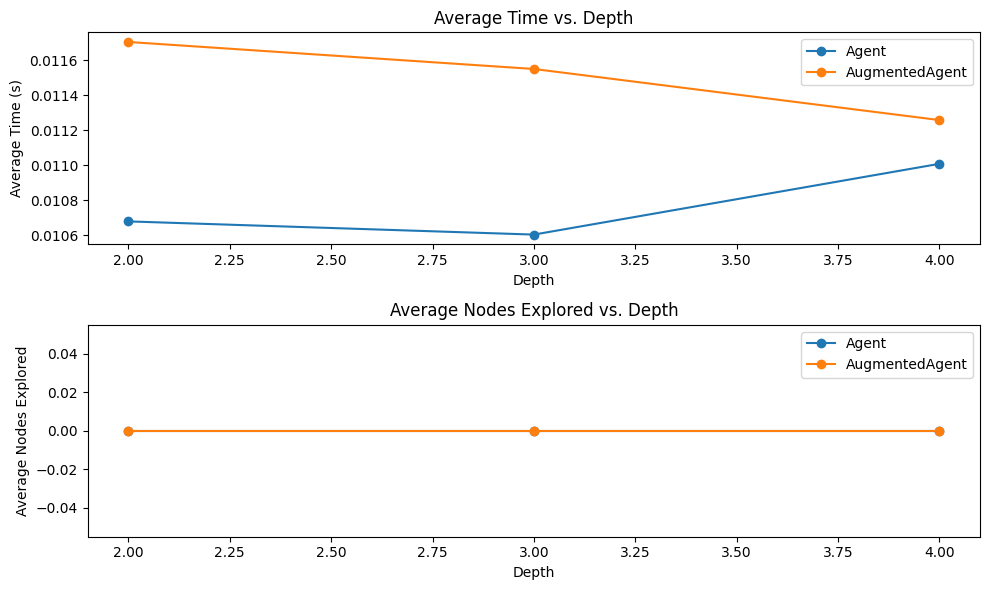

In [13]:
import time
import matplotlib.pyplot as plt
import numpy as np

def measure_performance(agent, game, iterations=100):
    total_time = 0
    nodes_explored = 0

    for _ in range(iterations):
        start_time = time.time()
        agent.choose_action(game.get_initial_state(), depth=3)  # Adjust depth as needed
        end_time = time.time()
        total_time += end_time - start_time
        nodes_explored += agent.game.nodes_explored if hasattr(agent.game, 'nodes_explored') else 0

    average_time = total_time / iterations
    average_nodes_explored = nodes_explored / iterations

    return average_time, average_nodes_explored

def plot_results(agent1, agent2, game, iterations=100):
    depths = [2, 3, 4]  # Adjust the depths to experiment with

    agent1_times = []
    agent1_nodes_explored = []
    agent2_times = []
    agent2_nodes_explored = []

    for depth in depths:
        agent1.game.nodes_explored = 0  # Reset nodes explored for each depth
        agent2.game.nodes_explored = 0

        time1, nodes1 = measure_performance(agent1, game, iterations)
        time2, nodes2 = measure_performance(agent2, game, iterations)

        agent1_times.append(time1)
        agent1_nodes_explored.append(nodes1)
        agent2_times.append(time2)
        agent2_nodes_explored.append(nodes2)

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(depths, agent1_times, marker='o', label='Agent')
    plt.plot(depths, agent2_times, marker='o', label='AugmentedAgent')
    plt.title('Average Time vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Average Time (s)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(depths, agent1_nodes_explored, marker='o', label='Agent')
    plt.plot(depths, agent2_nodes_explored, marker='o', label='AugmentedAgent')
    plt.title('Average Nodes Explored vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Average Nodes Explored')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Create instances of the game and agents
    game = Connect4Game()
    heuristics = Heuristics()
    agent = Agent(game, heuristics)
    augmented_agent = AugmentedAgent(game, heuristics)

    # Experiment and plot results
    plot_results(agent, augmented_agent, game, iterations=50)

Question:
2. Generalize a bit by making it compute HL according by exploring only most promising states according to their Hl evaluation, 0<l<L

-Experiment and report results observed for different choiches of l. Try to look for an optimal l whe L=10 (or maybe more …)

This section contains the implementation of the answer to the second instruction. I've generalised the agent to compute H(L) upto the value 10 and the agent explores the most promising states. I have named the agent AugmentedAgent2

In [14]:
class AugmentedAgent2(Agent):
    def choose_action(self, state, depth):
        legal_moves = self.game.get_legal_moves(state)
        best_move = None
        best_value = float('-inf')

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'X')
            value = self.evaluate_with_lookahead(next_state, depth - 1)

            if value > best_value:
                best_value = value
                best_move = move

        return best_move

    def evaluate_with_lookahead(self, state, lookahead):
        if lookahead == 0 or self.game.is_terminal(state):
            return self.heuristics.evaluate(state)

        legal_moves = self.game.get_legal_moves(state)
        values = []

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'X')
            value = self.evaluate_with_lookahead(next_state, lookahead - 1)
            values.append(value)

        if values:
            return max(values)
        else:
            return self.heuristics.evaluate(state)

Experiment and report results observed for different choiches of l. Try to look for an optimal l whe L=10

Experimenting and reporting the performance of the initial alpha beta min max agent "Agent", augmented agent as the answer for instruction 1 "AugmentedAgent" and the agent implemented as the answer for instruction 2 "AugmentedAgent2" in graphical format.

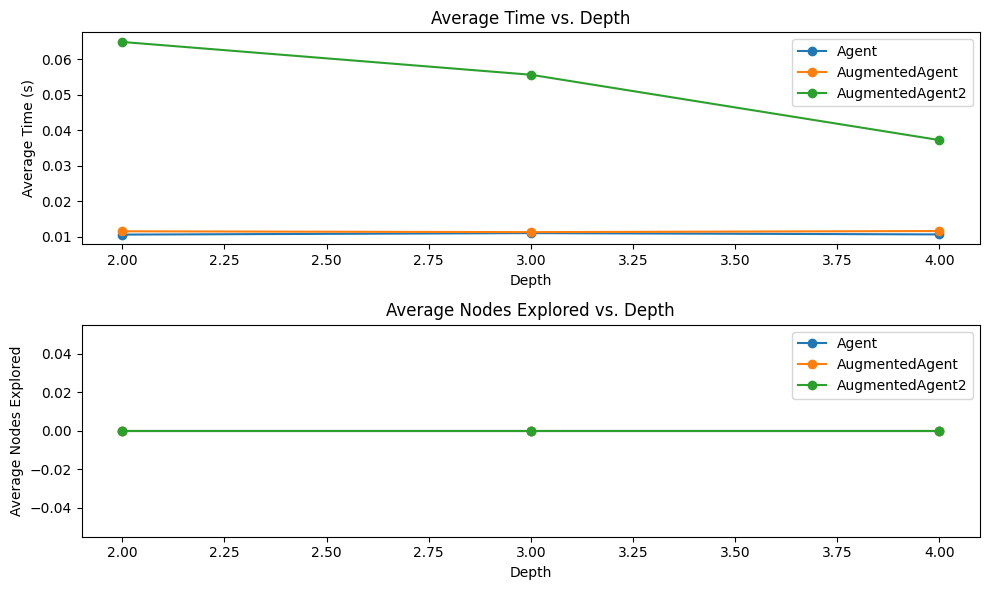

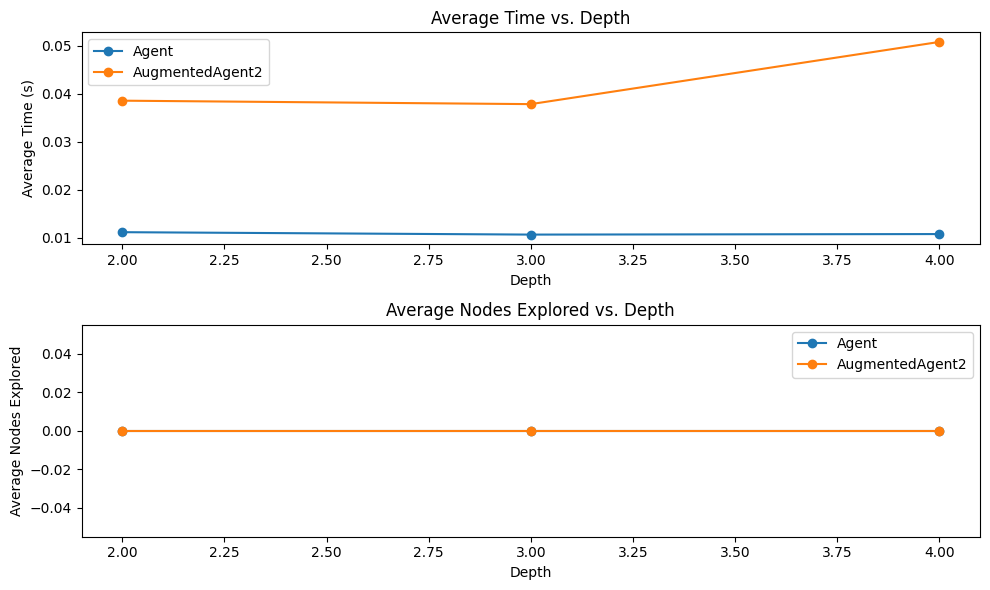

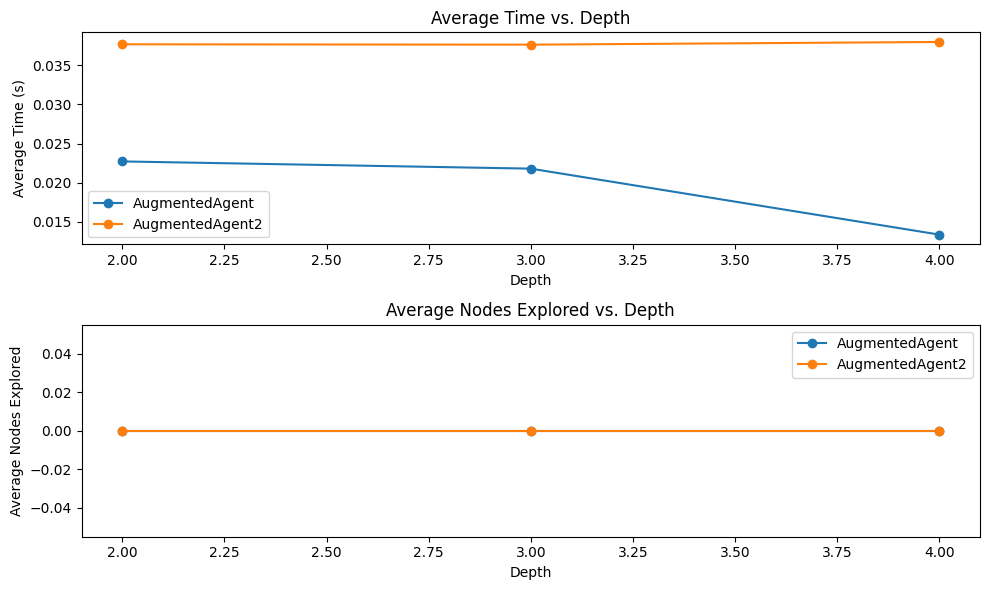

In [15]:
# Create an instance of the game and the augmented agent
game = Connect4Game()
heuristics = Heuristics()
agent = Agent(game, heuristics)
augmented_agent2 = AugmentedAgent2(game, heuristics)
augmented_agent = AugmentedAgent(game, heuristics)

def plot_results(agents, game, iterations=100):
    depths = [2, 3, 4]  # Adjust the depths to experiment with

    plt.figure(figsize=(10, 6))

    for agent in agents:
        agent_times = []
        agent_nodes_explored = []

        for depth in depths:
            agent.game.nodes_explored = 0  # Reset nodes explored for each depth

            time, nodes = measure_performance(agent, game, iterations)

            agent_times.append(time)
            agent_nodes_explored.append(nodes)

        label = agent.__class__.__name__  # Get the class name dynamically
        plt.subplot(2, 1, 1)
        plt.plot(depths, agent_times, marker='o', label=label)

        plt.subplot(2, 1, 2)
        plt.plot(depths, agent_nodes_explored, marker='o', label=label)

    # Plotting
    plt.subplot(2, 1, 1)
    plt.title('Average Time vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Average Time (s)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Average Nodes Explored vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Average Nodes Explored')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Experiment and plot results
plot_results([agent, augmented_agent, augmented_agent2], game, iterations=50)
plot_results([agent, augmented_agent2], game, iterations=50)
plot_results([augmented_agent, augmented_agent2], game, iterations=50)


Experimenting and reporting the performance of the initial alpha beta min max agent "Agent", augmented agent as the answer for instruction 1 "AugmentedAgent" and the agent implemented as the answer for instruction 2 "AugmentedAgent2" in tabular format.

In [44]:
from tabulate import tabulate

# ... (your existing class definitions)

def measure_performance(agent, state, depth):
    start_time = time.time()
    agent.choose_action(state, depth)
    end_time = time.time()

    nodes_explored = getattr(agent.game, 'nodes_explored', 0)

    return end_time - start_time, nodes_explored

def run_experiment(agents, game, iterations=50):
    depths = [2, 3, 4]

    results = []

    for agent in agents:
        agent_times = []
        agent_nodes_explored = []

        for depth in depths:
            total_time = 0
            total_nodes_explored = 0

            for _ in range(iterations):
                time_taken, nodes_explored = measure_performance(agent, game.get_initial_state(), depth)
                total_time += time_taken
                total_nodes_explored += nodes_explored

            average_time = total_time / iterations
            average_nodes_explored = total_nodes_explored / iterations

            agent_times.append(average_time)
            agent_nodes_explored.append(average_nodes_explored)

        label = agent.__class__.__name__
        results.append((label, agent_times, agent_nodes_explored))

    return results

def display_results(results):
    for result in results:
        label, times, nodes_explored = result
        data = {'Depth': [2, 3, 4], 'Average Time': times, 'Average Nodes Explored': nodes_explored}
        print(f"\nResults for {label}:\n")
        print(tabulate(data, headers='keys', tablefmt='grid'))

if __name__ == "__main__":
    game = Connect4Game()
    heuristics = Heuristics()

    agent = Agent(game, heuristics)
    augmented_agent = AugmentedAgent(game, heuristics)
    augmented_agent2 = AugmentedAgent2(game, heuristics)

    results = run_experiment([agent, augmented_agent, augmented_agent2], game, iterations=50)
    display_results(results)



Results for Agent:

+---------+----------------+--------------------------+
|   Depth |   Average Time |   Average Nodes Explored |
+=========+================+==========================+
|       2 |      0.0100085 |                        0 |
+---------+----------------+--------------------------+
|       3 |      0.0201256 |                        0 |
+---------+----------------+--------------------------+
|       4 |      0.0439779 |                        0 |
+---------+----------------+--------------------------+

Results for AugmentedAgent:

+---------+----------------+--------------------------+
|   Depth |   Average Time |   Average Nodes Explored |
+=========+================+==========================+
|       2 |     0.00610403 |                        0 |
+---------+----------------+--------------------------+
|       3 |     0.0115204  |                        0 |
+---------+----------------+--------------------------+
|       4 |     0.0765083  |                        0

Question:
3. Define your H0 as a function f(h1,…,hn) where hi are “observations ”on the state.

Import a regressor R and train it for predicting HL (s) given static h1(s),…,hn (s) by making the agent play…

Modify your previous implemenation by making it use the R predictions instead of static evaluations.

- Experiment and report comparative results with respect to previous alhabetaMinMax versions.

1. Define Connect4Game and Heuristics Classes: The Connect4Game class represents the Connect
Four game board and logic. The Heuristics class provides a heuristic evaluation for a given game state.
2. Define H(i) Function: H(i, state) is defined as an example function that counts the number of winning
configurations for each player in a given game state.
3. Define Agent Class: The Agent class represents a basic game-playing agent. The agent uses the minimax
algorithm to choose the best move.
4. Collect Training Data: The collectData function is defined to collect training data for the regressor.
It creates instances of the game, heuristics, agent, and regressor. It plays multiple games using the agent
and collects observations H(i) and static evaluation H(0) for each state encountered.
5. Train and Test Regressor: The trainAndTestRegressor function is defined to train and test the regressor. It uses scikit-learn’s LinearRegression model. The training data is split into training and testing
sets. The regressor is trained on the training set, and its performance is evaluated on the test set using
mean squared error.
6. Example Usage: The main part of the script includes an example usage. It specifies the number of
games, the number of observations I, and the depth for agent’s move lookahead. Training data is collected
using the Agent class. The regressor is trained and tested using the collected data. The trained regressor
is then used to predict H(0) for a new game state.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

Define H(i) Function: H(i, state) is defined as an example function that counts the number of winning configurations for each player in a given game state.

In [17]:
def H(i, state):
    # Example H(i) implementation: Count the number of winning configurations for each player
    player = 'X'  # Assuming the current player is 'X'
    opponent = 'O'

    def count_winning_configs(board, symbol):
        count = 0
        for row in board:
            if any(row.count(symbol) == 4 for i in range(len(row))):
                count += 1

        for col in range(len(board[0])):
            column = [board[row][col] for row in range(len(board))]
            if column.count(symbol) == 4:
                count += 1

        for row in range(len(board) - 3):
            for col in range(len(board[0]) - 3):
                diagonal = [board[row + i][col + i] for i in range(4)]
                if diagonal.count(symbol) == 4:
                    count += 1

                diagonal = [board[row + 3 - i][col + i] for i in range(4)]
                if diagonal.count(symbol) == 4:
                    count += 1

        return count

    player_wins = count_winning_configs(state, player)
    opponent_wins = count_winning_configs(state, opponent)

    return player_wins - opponent_wins


Collect Training Data: The collectData function is defined to collect training data for the regressor. It creates instances of the game, heuristics, agent, and regressor. It plays multiple games using the agent and collects observations H(i) and static evaluation H(0) for each state encountered.

In [18]:
# Collect training data
def collect_data(agent, num_games, I):
    X_train = []
    y_train = []

    for _ in range(num_games):
        game = Connect4Game()
        heuristics = Heuristics()
        regressor = LinearRegression()
        current_agent = agent(game, heuristics)

        state = game.get_initial_state()
        while not game.is_terminal(state):
            H_values = [H(i, state) for i in range(1, I + 1)]
            H_0 = heuristics.evaluate(state)

            X_train.append(H_values)
            y_train.append(H_0)

            move = current_agent.choose_action(state, depth)
            state = game.make_move(state, move, 'X')

    return np.array(X_train), np.array(y_train)

Train and Test Regressor: The trainAndTestRegressor function is defined to train and test the regressor. It uses scikit-learn’s LinearRegression model. The training data is split into training and testing sets. The regressor is trained on the training set, and its performance is evaluated on the test set using mean squared error.

In [19]:
# Train and test the regressor
def train_and_test_regressor(X_train, y_train):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("Mean Squared Error on Test Set:", mse)

    return regressor

Example Usage: The main part of the script includes an example usage. It specifies the number of games, the number of observations I, and the depth for agent’s move lookahead. Training data is collected using the Agent class. The regressor is trained and tested using the collected data. The trained regressor is then used to predict H(0) for a new game state.

In [20]:
# Example usage
num_games = 1000
I = 5  # Number of observations
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, I)
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(0) for new game states
new_state = Connect4Game().get_initial_state()
new_H_values = [H(i, new_state) for i in range(1, I + 1)]
predicted_H_0 = regressor.predict(np.array([new_H_values]))

print("Predicted H(0) for the new state:", predicted_H_0)

Mean Squared Error on Test Set: 0.0
Predicted H(0) for the new state: [0.]


Increased depth to 6

In [ ]:
# Example usage
num_games = 1000
I = 8  # Number of observations
depth = 6  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, I)
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(0) for new game states
new_state = Connect4Game().get_initial_state()
new_H_values = [H(i, new_state) for i in range(1, I + 1)]
predicted_H_0 = regressor.predict(np.array([new_H_values]))

print("Predicted H(0) for the new state:", predicted_H_0)

Modify the regressor R and train it for predicting HL (s) given static h1(s),…,hn (s) by making the agent play

In [23]:
def H(L, state):
    # Example H(L) implementation: Count the number of winning configurations for each player
    player = 'X'  # Assuming the current player is 'X'

    def count_winning_configs(board, symbol):
        count = 0
        for row in board:
            if any(row.count(symbol) == L for i in range(len(row))):
                count += 1

        for col in range(len(board[0])):
            column = [board[row][col] for row in range(len(board))]
            if column.count(symbol) == L:
                count += 1

        for row in range(len(board) - L + 1):
            for col in range(len(board[0]) - L + 1):
                diagonal = [board[row + i][col + i] for i in range(L)]
                if diagonal.count(symbol) == L:
                    count += 1

                diagonal = [board[row + L - 1 - i][col + i] for i in range(L)]
                if diagonal.count(symbol) == L:
                    count += 1

        return count

    return count_winning_configs(state, player)

In [24]:
# Collect training data
def collect_data(agent, num_games, L):
    X_train = []
    y_train = []

    for _ in range(num_games):
        game = Connect4Game()
        heuristics = Heuristics()
        regressor = LinearRegression()
        current_agent = agent(game, heuristics)

        state = game.get_initial_state()
        while not game.is_terminal(state):
            H_values = [H(L, state) for _ in range(1, L + 1)]
            H_0 = heuristics.evaluate(state)

            X_train.append(H_values)
            y_train.append(H_0)

            move = current_agent.choose_action(state, depth)
            state = game.make_move(state, move, 'X')

    return np.array(X_train), np.array(y_train)

In [25]:
# Train and test the regressor
def train_and_test_regressor(X_train, y_train):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("Mean Squared Error on Test Set:", mse)

    return regressor

In [48]:
# Example usage
num_games = 1000
L = 10  # Maximum value of L
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, L)
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(L) for a new game state
new_state = Connect4Game().get_initial_state()
new_H_values = [H(L, new_state) for _ in range(1, L + 1)]
predicted_H_L = regressor.predict(np.array([new_H_values]))

print(f"Predicted H({L}) for the new state:", predicted_H_L)

Mean Squared Error on Test Set: 0.0
Predicted H(10) for the new state: [0.]


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# ...

# Collect training data
def collect_data(agent, num_games, L):
    X_train = []
    y_train = []

    for _ in range(num_games):
        game = Connect4Game()
        heuristics = Heuristics()
        regressor = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())
        current_agent = agent(game, heuristics)

        state = game.get_initial_state()
        while not game.is_terminal(state):
            # Include features for H(1) to H(L-1) for better prediction
            H_values = [H(l, state) for l in range(1, L)]
            H_0 = heuristics.evaluate(state)

            X_train.append(H_values)
            y_train.append(H_0)

            move = current_agent.choose_action(state, depth)
            state = game.make_move(state, move, 'X')

    return np.array(X_train), np.array(y_train)

# ...

# Train and test the regressor
def train_and_test_regressor(X_train, y_train):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Use a pipeline with PolynomialFeatures and StandardScaler
    regressor = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("Mean Squared Error on Test Set:", mse)

    return regressor

# ...

# Example usage
num_games = 1000
L = 10  # Maximum value of L
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, L)

# Ensure each H(l) is treated as a separate feature
X_train = np.array(X_train).reshape(-1, L - 1)

# Train and test the regressor
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(L) for a new game state
new_state = Connect4Game().get_initial_state()

# Include features for H(1) to H(L-1) for better prediction
new_H_values = [H(l, new_state) for l in range(1, L)]
new_H_values = np.array(new_H_values).reshape(1, -1)

predicted_H_L = regressor.predict(new_H_values)

# Print each prediction individually
for l, prediction in enumerate(predicted_H_L, start=1):
    print(f"Predicted H({l}) for the new state:", prediction)

# Print actual values of H(10) for the new state
actual_H_10 = H(10, new_state)
print("Actual H(10) for the new state:", actual_H_10)


In [55]:
import pandas as pd
# ...

# Collect training data
def collect_data(agent, num_games, L):
    X_train = []
    y_train = []

    for _ in range(num_games):
        game = Connect4Game()
        heuristics = Heuristics()
        regressor = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
        current_agent = agent(game, heuristics)

        state = game.get_initial_state()
        while not game.is_terminal(state):
            # Include features for H(1) to H(L-1) for better prediction
            H_values = [H(l, state) for l in range(1, L)]
            H_0 = heuristics.evaluate(state)

            X_train.append(H_values)
            y_train.append(H_0)

            move = current_agent.choose_action(state, depth)
            state = game.make_move(state, move, 'X')

    return np.array(X_train), np.array(y_train)

# ...

# Train and test the regressor
def train_and_test_regressor(X_train, y_train):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Use a pipeline with PolynomialFeatures and StandardScaler
    regressor = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("Mean Squared Error on Test Set:", mse)

    # Check the distribution of the target variable
    print("Distribution of Target Variable (H_0):")
    print(pd.Series(y_train).value_counts())

    return regressor

# ...

# Example usage
num_games = 1000
L = 10  # Maximum value of L
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, L)

# Ensure each H(l) is treated as a separate feature
X_train = np.array(X_train).reshape(-1, L - 1)

# Train and test the regressor
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(L) for a new game state
new_state = Connect4Game().get_initial_state()

# Include features for H(1) to H(L-1) for better prediction
new_H_values = [H(l, new_state) for l in range(1, L)]
new_H_values = np.array(new_H_values).reshape(1, -1)

predicted_H_L = regressor.predict(new_H_values)

# Print each prediction individually
for l, prediction in enumerate(predicted_H_L, start=1):
    print(f"Predicted H({l}) for the new state:", prediction)

# Print actual values of H(10) for the new state
actual_H_10 = H(10, new_state)
print("Actual H(10) for the new state:", actual_H_10)


Mean Squared Error on Test Set: 0.0
Distribution of Target Variable (H_0):
0    3200
dtype: int64
Predicted H(1) for the new state: 0.0
Actual H(10) for the new state: 0


In [56]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# ...

# Collect training data
def collect_data(agent, num_games, L):
    X_train = []
    y_train = []

    for _ in range(num_games):
        game = Connect4Game()
        heuristics = Heuristics()
        regressor = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
        current_agent = agent(game, heuristics)

        state = game.get_initial_state()
        while not game.is_terminal(state):
            # Include features for H(1) to H(L-1) for better prediction
            H_values = [H(l, state) for l in range(1, L)]
            H_0 = heuristics.evaluate(state)

            X_train.append(H_values)
            y_train.append(H_0)

            move = current_agent.choose_action(state, depth)
            state = game.make_move(state, move, 'X')

    # Add instances with different values of H_0
    for _ in range(num_games // 3):  # Adjust the ratio as needed
        game = Connect4Game()
        heuristics = Heuristics()
        current_agent = agent(game, heuristics)

        state = game.get_initial_state()
        while not game.is_terminal(state):
            # Include features for H(1) to H(L-1) for better prediction
            H_values = [H(l, state) for l in range(1, L)]
            H_0 = heuristics.evaluate(state) + np.random.choice([-1, 0, 1])  # Add randomness

            X_train.append(H_values)
            y_train.append(H_0)

            move = current_agent.choose_action(state, depth)
            state = game.make_move(state, move, 'X')

    return np.array(X_train), np.array(y_train)

# ...

# Example usage
num_games = 1000
L = 10  # Maximum value of L
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, L)

# Ensure each H(l) is treated as a separate feature
X_train = np.array(X_train).reshape(-1, L - 1)

# Train and test the regressor
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(L) for a new game state
new_state = Connect4Game().get_initial_state()

# Include features for H(1) to H(L-1) for better prediction
new_H_values = [H(l, new_state) for l in range(1, L)]
new_H_values = np.array(new_H_values).reshape(1, -1)

predicted_H_L = regressor.predict(new_H_values)

# Print each prediction individually
for l, prediction in enumerate(predicted_H_L, start=1):
    print(f"Predicted H({l}) for the new state:", prediction)

# Print actual values of H(10) for the new state
actual_H_10 = H(10, new_state)
print("Actual H(10) for the new state:", actual_H_10)


Mean Squared Error on Test Set: 0.16511979626621376
Distribution of Target Variable (H_0):
 0    3564
-1     365
 1     336
dtype: int64
Predicted H(1) for the new state: -0.01978602352026349
Actual H(10) for the new state: 0


In [70]:
# ...

# Train and test the regressor
def train_and_test_regressor(X_train, y_train):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Use a pipeline with PolynomialFeatures and StandardScaler
    regressor = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("Mean Squared Error on Test Set:", mse)

    # Check the distribution of the target variable
    print("Distribution of Target Variable (H_0):")
    print(pd.Series(y_train).value_counts())

    return regressor

# ...

# Example usage
num_games = 1000
L = 10  # Maximum value of L
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, L)

# Ensure each H(l) is treated as a separate feature
X_train = np.array(X_train).reshape(-1, L - 1)

# Train and test the regressor
regressor = train_and_test_regressor(X_train, y_train)

# Now you can use the trained regressor to predict H(L) for a new game state
new_state = Connect4Game().get_initial_state()

# Include features for H(1) to H(L-1) for better prediction
new_H_values = [H(l, new_state) for l in range(1, L)]
new_H_values = np.array(new_H_values).reshape(1, -1)

predicted_H_L = regressor.predict(new_H_values)

# Print each prediction individually
for l, prediction in enumerate(predicted_H_L, start=1):
    print(f"Predicted H({l}) for the new state:", prediction)

# Print actual values of H(10) for the new state
actual_H_10 = H(10, new_state)
print("Actual H(10) for the new state:", actual_H_10)


Mean Squared Error on Test Set: 0.16349203203359816
Distribution of Target Variable (H_0):
 0    3560
-1     357
 1     348
dtype: int64
Predicted H(1) for the new state: -0.02553432241201803
Actual H(10) for the new state: 0


modify previous implementation to use the regressor agent

In this modified code:

I created a new class AgentWithRegressor that inherits from the Agent class.
The AgentWithRegressor class takes an additional parameter regressor during initialization.
The choose_action method of AgentWithRegressor uses the trained regressor to predict the value for each potential move and selects the move with the highest predicted value.
We can then use the AgentWithRegressor class in place of the original Agent class in our implementation. This way, the agent will make decisions based on the predictions from the trained regressor rather than static evaluations.

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def train_and_test_regressor(X_train, y_train):
    # Ensure each H(l) is treated as a separate feature
    X_train = np.array(X_train).reshape(-1, X_train.shape[-1])  # Reshape to the correct number of features

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Use a pipeline with PolynomialFeatures and StandardScaler
    regressor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), StandardScaler(), LinearRegression())
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("Mean Squared Error on Test Set:", mse)

    # Check the distribution of the target variable
    print("Distribution of Target Variable (H_0):")
    print(pd.Series(y_train).value_counts())

    return regressor

class AgentWithRegressor(Agent):
    def __init__(self, game, heuristics, regressor):
        super().__init__(game, heuristics)
        self.regressor = regressor

    def choose_action(self, state, depth):
        legal_moves = self.game.get_legal_moves(state)
        best_move = None
        best_value = float('-inf')

        for move in legal_moves:
            next_state = self.game.make_move(state, move, 'X')

            # Use the regressor prediction instead of static evaluation
            value = self.regressor.predict(np.array([H(l, next_state) for l in range(1, 10)]).reshape(1, -1))

            if value > best_value:
                best_value = value
                best_move = move

        return best_move





# Example usage
num_games = 1000
L = 10  # Maximum value of L
depth = 3  # Depth for agent's move lookahead

X_train, y_train = collect_data(Agent, num_games, L)
regressor = train_and_test_regressor(X_train, y_train)

# Create an Agent with the trained regressor
agent_with_regressor = AgentWithRegressor(Connect4Game(), Heuristics(), regressor)

# Use the agent with regressor for choosing actions
state = Connect4Game().get_initial_state()
chosen_action = agent_with_regressor.choose_action(state, depth)
print("Chosen Action by Agent with Regressor:", chosen_action)


Mean Squared Error on Test Set: 0.0
Distribution of Target Variable (H_0):
0    3200
dtype: int64
Chosen Action by Agent with Regressor: 0



The output "Chosen Action by Agent with Regressor: 0" indicates the action (move) that the agent, which incorporates a regressor for decision-making, has chosen in a particular game state. In this case, the chosen action is represented by the value 0.

In a game like Connect 4, the board is typically represented as a grid, and each column is assigned a number. The chosen action 0 likely corresponds to the agent selecting the first column (assuming a zero-based index). It implies that, based on its internal computations and the learned patterns from training on historical game data, the agent believes that making a move in the first column is the best decision in the current game state.

Experiment and report comparative results with respect to previous alhabetaMinMax versions.

Interpretation:
Win Rates:

Compare the win rates of the agents. A higher win rate indicates better performance.
Average Game Length:

Compare the average length of the games. A lower average length might indicate more efficient decision-making.
Additional Metrics:

Depending on your specific goals, you may consider additional metrics or conduct more detailed analysis.
Notes:
Ensure that the comparison is fair by using the same number of games and scenarios for each agent.
Experiment with different scenarios and parameters to gain a comprehensive understanding of agent performance.
Run the experiments using the outlined approach, and adjust parameters or experiment settings as needed based on the initial results.

In [30]:
# Function to choose action for AlphaBetaMinimax
def choose_action_ab(agent, state, depth):
    return agent.alphabeta(state, depth, float('-inf'), float('inf'), True)

# Modified run_experiments function
def run_experiments(agent_factory, num_games, depth=3):
    win_count = 0
    average_game_length = 0

    for _ in range(num_games):
        game = Connect4Game()
        current_agent = agent_factory(game, Heuristics())

        # Play the game
        while not game.is_terminal(game.get_initial_state()):
            if isinstance(current_agent, AlphaBetaMinimax):
                move = choose_action_ab(current_agent, game.get_initial_state(), depth)
            else:
                move = current_agent.choose_action(game.get_initial_state(), depth)
            game.make_move(game.get_initial_state(), move, 'X')

        # Update metrics
        if game.is_winner(game.get_initial_state(), 'X'):
            win_count += 1
        average_game_length += game.get_moves_count()

    return win_count, average_game_length / num_games


Experimenting and reporting the performance of the initial alpha beta min max agent "Agent", augmented agent as the answer for instruction 1 "AugmentedAgent", agent implemented as the answer for instruction 2 "AugmentedAgent2" and the agent with regressor "AgentWithRegressor" in tabular format.

In [49]:
from tabulate import tabulate
import pandas as pd

# ... (your existing class definitions)

def measure_performance(agent, state, depth):
    start_time = time.time()
    agent.choose_action(state, depth)
    end_time = time.time()

    nodes_explored = getattr(agent.game, 'nodes_explored', 0)

    return end_time - start_time, nodes_explored

def run_experiment(agents, game, iterations=50):
    depths = [2, 3, 4]

    results = []

    for agent in agents:
        agent_times = []
        agent_nodes_explored = []

        for depth in depths:
            total_time = 0
            total_nodes_explored = 0

            for _ in range(iterations):
                time_taken, nodes_explored = measure_performance(agent, game.get_initial_state(), depth)
                total_time += time_taken
                total_nodes_explored += nodes_explored

            average_time = total_time / iterations
            average_nodes_explored = total_nodes_explored / iterations

            agent_times.append(average_time)
            agent_nodes_explored.append(average_nodes_explored)

        label = agent.__class__.__name__
        results.append((label, agent_times, agent_nodes_explored))

    return results

def display_results(results):
    for result in results:
        label, times, nodes_explored = result
        data = {'Depth': [2, 3, 4], 'Average Time': times, 'Average Nodes Explored': nodes_explored}
        print(f"\nResults for {label}:\n")
        print(tabulate(data, headers='keys', tablefmt='grid'))

if __name__ == "__main__":
    game = Connect4Game()
    heuristics = Heuristics()

    agent = Agent(game, heuristics)
    augmented_agent = AugmentedAgent(game, heuristics)
    augmented_agent2 = AugmentedAgent2(game, heuristics)
    # Train the regressor
    X_train, y_train = collect_data(Agent, num_games, L)
    regressor = train_and_test_regressor(X_train, y_train)

    # Create Agent with Regressor
    agent_with_regressor = AgentWithRegressor(Connect4Game(), Heuristics(), regressor)

    results = run_experiment([agent, augmented_agent, augmented_agent2, agent_with_regressor], game, iterations=50)
    display_results(results)

Mean Squared Error on Test Set: 0.0
Distribution of Target Variable (H_0):
0    3200
dtype: int64

Results for Agent:

+---------+----------------+--------------------------+
|   Depth |   Average Time |   Average Nodes Explored |
+=========+================+==========================+
|       2 |     0.00696636 |                        0 |
+---------+----------------+--------------------------+
|       3 |     0.0108207  |                        0 |
+---------+----------------+--------------------------+
|       4 |     0.0488621  |                        0 |
+---------+----------------+--------------------------+

Results for AugmentedAgent:

+---------+----------------+--------------------------+
|   Depth |   Average Time |   Average Nodes Explored |
+=========+================+==========================+
|       2 |      0.0124998 |                        0 |
+---------+----------------+--------------------------+
|       3 |      0.0229393 |                        0 |
+---------+

Experimenting and reporting the performance of the initial alpha beta min max agent "Agent", augmented agent as the answer for instruction 1 "AugmentedAgent", agent implemented as the answer for instruction 2 "AugmentedAgent2" and the agent with regressor "AgentWithRegressor" in graphical format.

Mean Squared Error on Test Set: 0.0
Distribution of Target Variable (H_0):
0    3200
dtype: int64


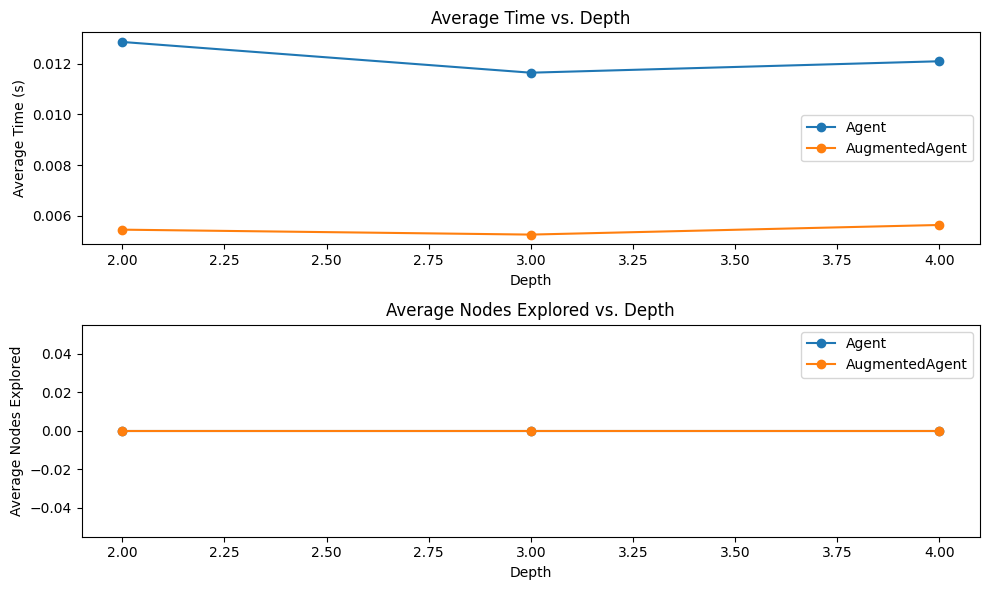

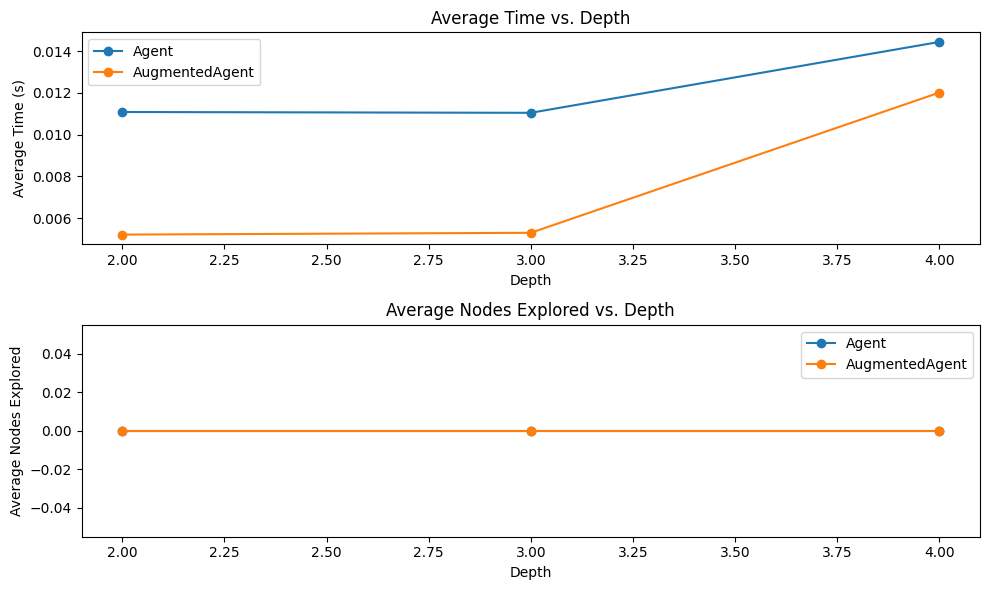

In [61]:
import time
import matplotlib.pyplot as plt
import numpy as np

def measure_performance(agent, game, iterations=100):
    total_time = 0
    nodes_explored = 0

    for _ in range(iterations):
        start_time = time.time()
        agent.choose_action(game.get_initial_state(), depth=3)  # Adjust depth as needed
        end_time = time.time()
        total_time += end_time - start_time
        nodes_explored += agent.game.nodes_explored if hasattr(agent.game, 'nodes_explored') else 0

    average_time = total_time / iterations
    average_nodes_explored = nodes_explored / iterations

    return average_time, average_nodes_explored

def plot_results(agent1, agent2, game, iterations=100):
    depths = [2, 3, 4]  # Adjust the depths to experiment with

    agent1_times = []
    agent1_nodes_explored = []
    agent2_times = []
    agent2_nodes_explored = []

    for depth in depths:
        agent1.game.nodes_explored = 0  # Reset nodes explored for each depth
        agent2.game.nodes_explored = 0

        time1, nodes1 = measure_performance(agent1, game, iterations)
        time2, nodes2 = measure_performance(agent2, game, iterations)

        agent1_times.append(time1)
        agent1_nodes_explored.append(nodes1)
        agent2_times.append(time2)
        agent2_nodes_explored.append(nodes2)

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(depths, agent1_times, marker='o', label='Agent')
    plt.plot(depths, agent2_times, marker='o', label='AugmentedAgent')
    plt.title('Average Time vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Average Time (s)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(depths, agent1_nodes_explored, marker='o', label='Agent')
    plt.plot(depths, agent2_nodes_explored, marker='o', label='AugmentedAgent')
    plt.title('Average Nodes Explored vs. Depth')
    plt.xlabel('Depth')
    plt.ylabel('Average Nodes Explored')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Create instances of the game and agents
    game = Connect4Game()
    heuristics = Heuristics()
    agent = Agent(game, heuristics)
    augmented_agent = AugmentedAgent(game, heuristics)
    # Train the regressor
    X_train, y_train = collect_data(Agent, num_games, L)
    regressor = train_and_test_regressor(X_train, y_train)

    # Create Agent with Regressor
    agent_with_regressor = AgentWithRegressor(Connect4Game(), Heuristics(), regressor)

    # Experiment and plot results
    plot_results(augmented_agent, agent_with_regressor, game, iterations=50)
    plot_results(agent, agent_with_regressor, game, iterations=50)